# CQF - Exam 2

### Imports

In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

Parameters

In [3]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 200
dt = T / N
ts = np.arange(0, T, dt)
dB = np.random.randn(N) * np.sqrt(dt)
B = np.cumsum(dB)

### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

<AxesSubplot:>

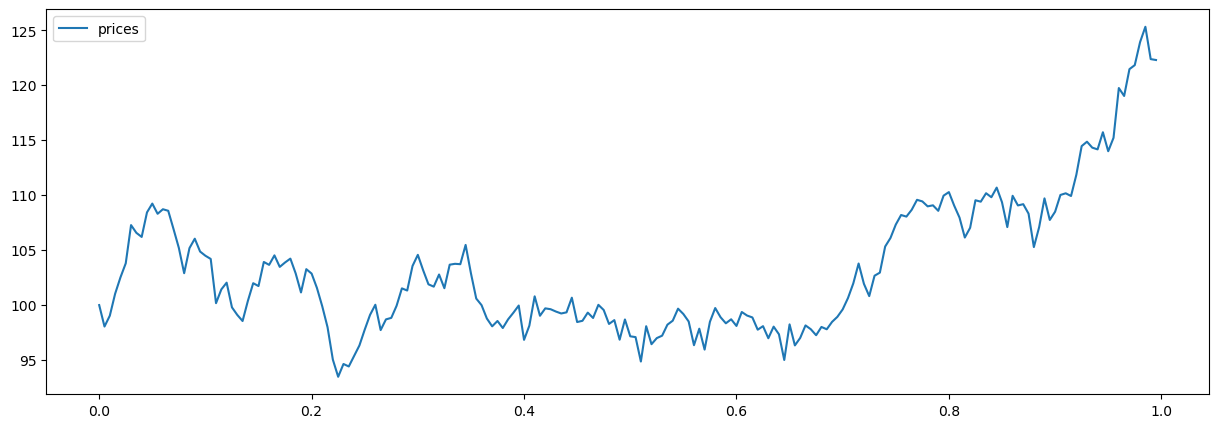

In [4]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

em_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
em_df.plot(colormap='tab10', figsize=[15,5])

### Milstein schema

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

<AxesSubplot:>

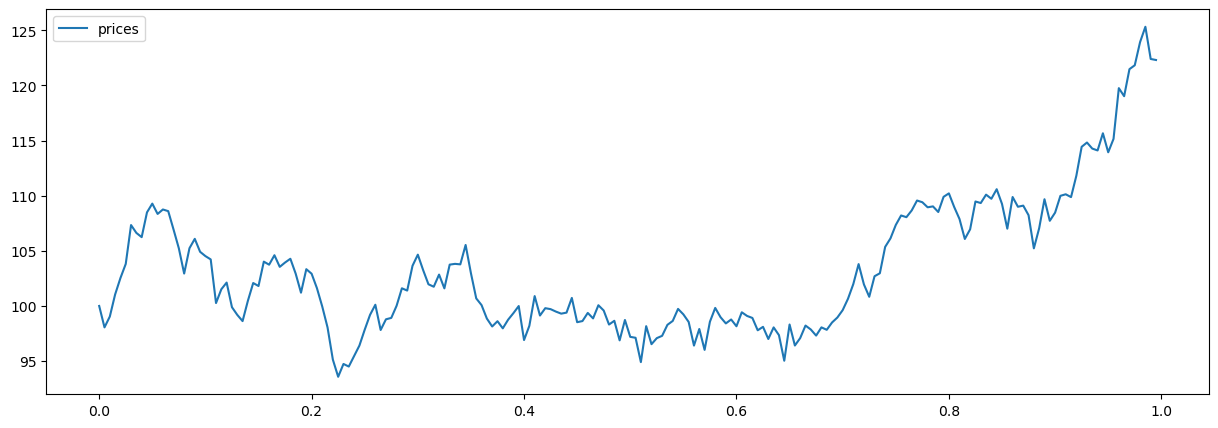

In [5]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
        + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

milstein_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
milstein_df.plot(colormap='tab10', figsize=[15,5])

### Closed Form Solution

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t))}
$$

<AxesSubplot:>

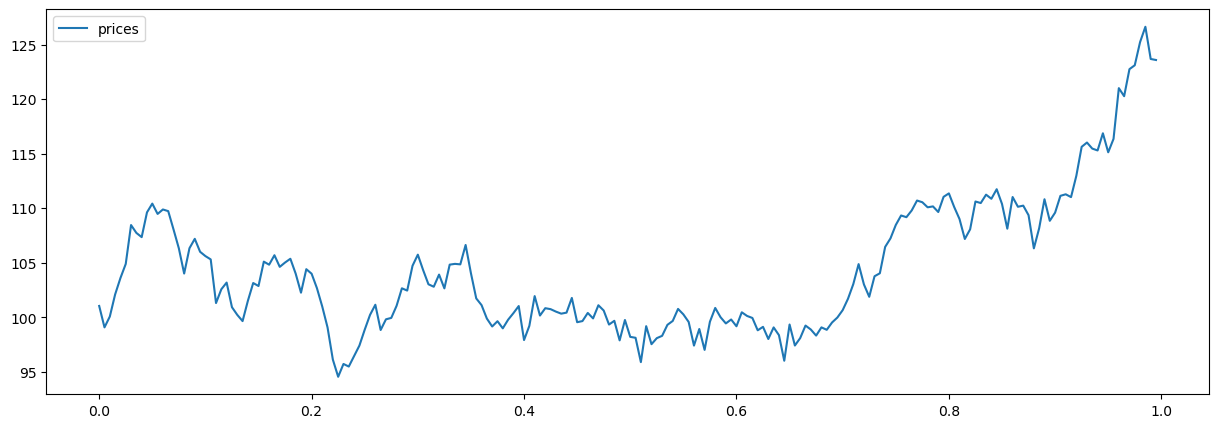

In [6]:
S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
closed_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
closed_df.plot(colormap='tab10', figsize=[15,5])

### Schemas Comparison

<AxesSubplot:>

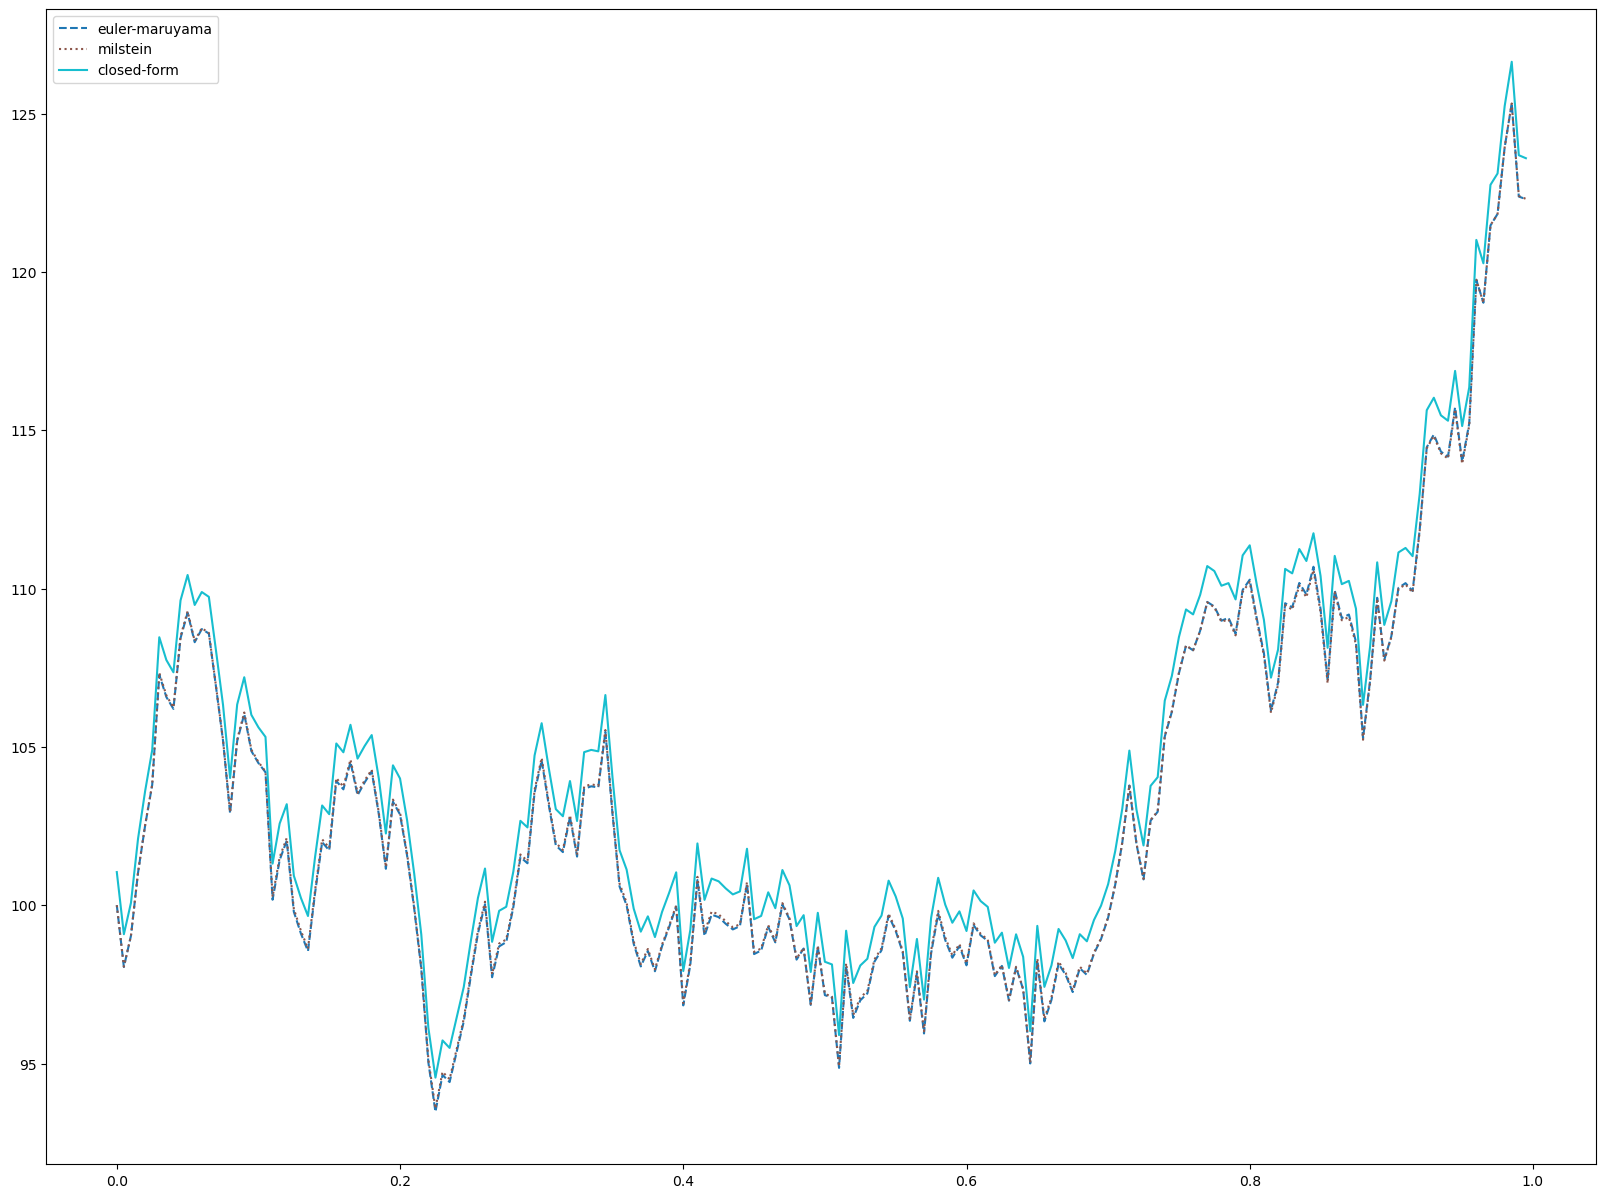

In [7]:
compare_df = em_df.copy()
compare_df.columns = ['euler-maruyama']
compare_df['milstein'] = milstein_df['prices']
compare_df['closed-form'] = closed_df['prices']
compare_df.plot(style=['--', ':', '-'],colormap='tab10', figsize=[20,15])

Plot above shows that Milstein method gives us a better approximation to the close form solution. The Milstein method has an error of $O(\delta t^2)$ while Euler-Maruyama has an error of $O(\delta t)$. 

### Asian Option Payoffs

In [8]:
n_simul = 10000
simulations = [np.random.randn(N) * np.sqrt(dt) for i in range(n_simul)]

euler_paths = [] 
milstein_paths = [] 
close_paths = []

for s in simulations:
    B = np.cumsum(s)
    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i]

    euler_paths.append(S)

    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i] \
            + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

    milstein_paths.append(S)

    S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
    close_paths.append(S)

Cheching if paths are been generated accordingly

Text(0.5, 1.0, 'close form paths')

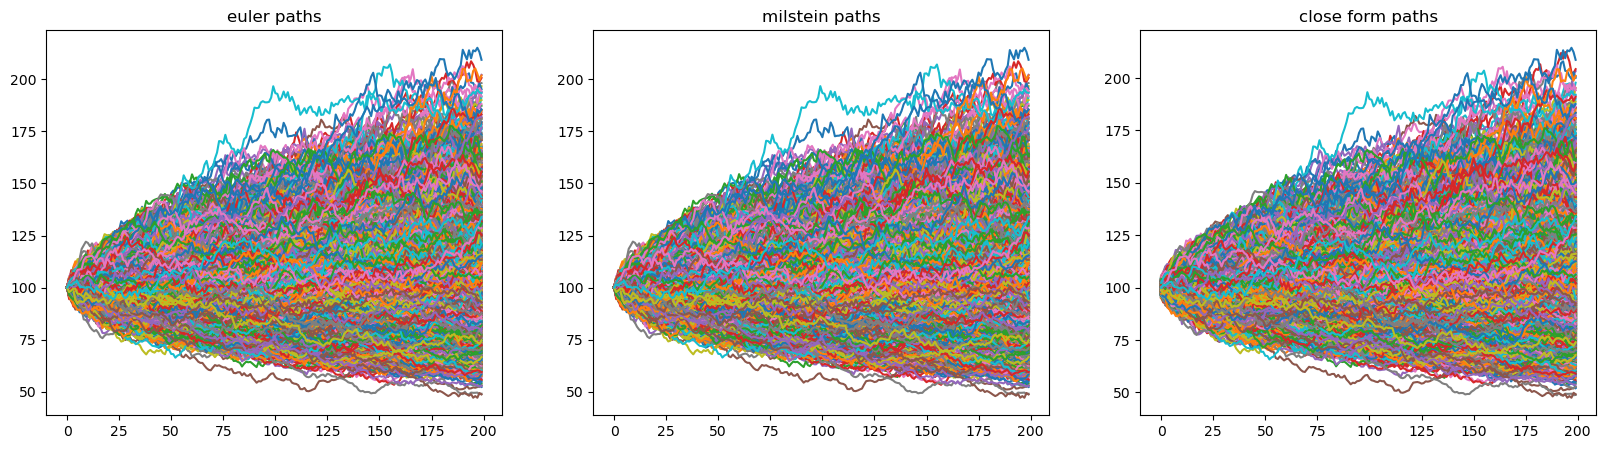

In [9]:
figure, axis = plt.subplots(1, 3, figsize=[20, 5])

for s in euler_paths:
    axis[0].plot(s)
axis[0].set_title('euler paths')

for s in milstein_paths:
    axis[1].plot(s)
axis[1].set_title('milstein paths')

for s in close_paths:
    axis[2].plot(s)
axis[2].set_title('close form paths')

In [10]:
def vanilla_payoff(S, K, CP):
    return max(S[-1]-K, 0) if CP == 'C' else max(K-S[-1], 0)

def asian_payoff(S, K, CP, avg_func, fixed_strike=True):
    if CP == 'C':
        return max(avg_func(S)-K, 0) if fixed_strike else max(S[-1]-avg_func(S), 0)
    else:
        return max(K-avg_func(S), 0) if fixed_strike else max(avg_func(S)-S[-1], 0)
    
E = 100

df = pd.DataFrame(index=['euler-maruyama','milstein', 'closed'], data=[
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in euler_paths]), 
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in euler_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in milstein_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, fixed_strike=False) for S in close_paths])
    ]],
    columns=['call mean fixed strike', 'put mean fixed strike', 'call mean float strie', 'put mean float strike', 'call gmean fixed strike', 'put gmean fixed strike', 'call gmean float strike', 'put gmean float strike'])

df

,call mean fixed strike,put mean fixed strike,call mean float strie,put mean float strike,call gmean fixed strike,put gmean fixed strike,call gmean float strike,put gmean float strike
euler-maruyama,5.694913,3.345987,5.817592,3.331539,5.483831,3.464514,6.022919,3.207257
milstein,5.712639,3.333274,5.805604,3.342576,5.502076,3.451987,6.009812,3.217509
closed,5.750526,3.369631,5.818799,3.333171,5.538407,3.487274,6.024429,3.209037


In [11]:
ts

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

## Question 3 - Monte Carlo Integration

Define function for Monte Carlo integration

In [12]:
def monte_carlo_integration(func, N, limit_inf, limit_sup):
    xs = np.random.uniform(limit_inf, limit_sup, size=N)
    ys = [func(x) for x in xs]
    return (limit_sup - limit_inf) / N * np.sum(ys)

I.
$$
\int_{1}^{3}x^2dx = \frac{1}{3}x^3\Biggr|_{1}^{3} =  \frac{26}{3} = 8.666667
$$

In [13]:
def func(x):
    return x**2

exact_value = 8.666667
limit_inf = 1
limit_sup = 3

In [14]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,8.666667,5.321044,3.345623
20,8.666667,10.144721,-1.478054
40,8.666667,8.402331,0.264336
80,8.666667,8.904533,-0.237866
160,8.666667,9.029305,-0.362638
320,8.666667,8.665132,0.001535
640,8.666667,8.855490,-0.188823
1280,8.666667,8.671828,-0.005161
2560,8.666667,8.575981,0.090686
5120,8.666667,8.671532,-0.004865


Text(0, 0.5, 'error')

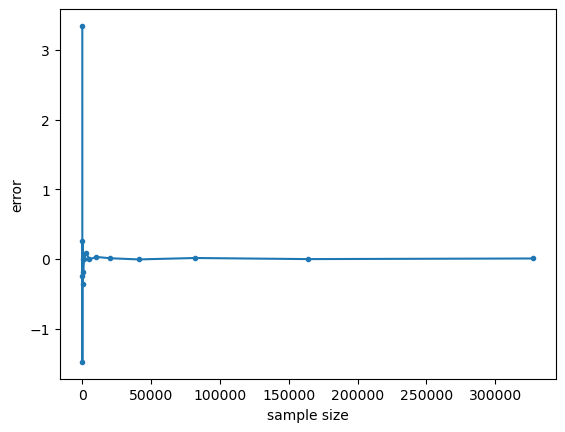

In [15]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

II.
$$
\int_{0}^{\infty}e^{-x^2}dx = \frac{1}{2}\sqrt\pi \text{erf} (x) \approx 0.886227
$$

In [16]:
def func(x):
    return np.exp(-x**2)

exact_value = 0.886227
limit_inf = 0
limit_sup = 500

In [17]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,0.886227,4.769397e+01,-46.807745
20,0.886227,0.000000e+00,0.886227
40,0.886227,1.594199e-25,0.886227
80,0.886227,2.093210e+00,-1.206983
160,0.886227,3.039542e-04,0.885923
320,0.886227,3.151276e-02,0.854714
640,0.886227,8.049859e-07,0.886226
1280,0.886227,2.445754e-01,0.641652
2560,0.886227,1.430657e+00,-0.544430
5120,0.886227,8.023412e-01,0.083886


Text(0, 0.5, 'error')

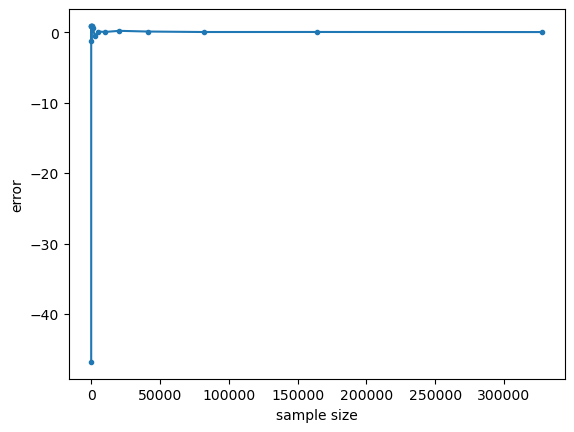

In [18]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

III.

$$
\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x^{4}e^{-x^2/2}dx = 0.398942 \left( 3\sqrt{\frac{\pi}{2}} \text{erf} \left(\frac{x}{\sqrt{2}}\right) - e^{-x^2/2} x ( x^2 + 3) \right) = 3
$$

In [19]:
def func(x):
    return ( 1.0 / np.sqrt(2*np.pi) ) * x**4 * np.exp(-x**2 / 2)

exact_value = 3.
limit_inf = -500
limit_sup = 500

In [20]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920, 163840, 327680]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,3.0,0.000000e+00,3.000000
20,3.0,3.229861e-81,3.000000
40,3.0,3.941038e-01,2.605896
80,3.0,1.313352e-71,3.000000
160,3.0,4.498216e+00,-1.498216
320,3.0,6.777411e-01,2.322259
640,3.0,4.417732e+00,-1.417732
1280,3.0,2.599163e+00,0.400837
2560,3.0,2.576825e+00,0.423175
5120,3.0,3.517674e+00,-0.517674


Text(0, 0.5, 'error')

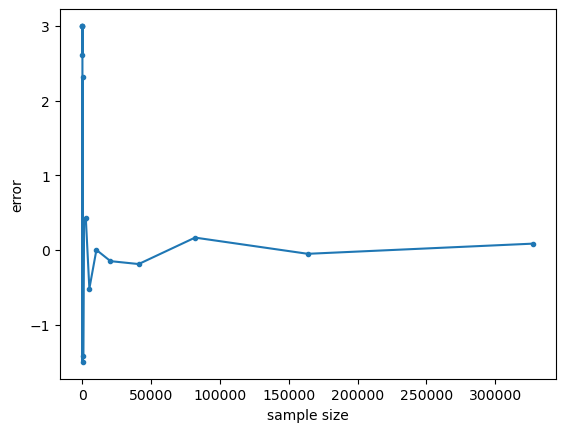

In [21]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

Hence, the plots above shows that as we increase the samples size, the error to the exact solution gets closer to $0$.

## References

- Wilmott, Paul. 2006. Paul Wilmott on Quantitative Finance. 2nd ed. Hoboken, NJ: John Wiley & Sons.